# <span style="color:#91299A">Основные уравнения движения</span> 

![](../storage/banners/4.png)

### <span style="color:#0ab49a">Системы координат</span>

In [53]:
import PIL
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib import animation

In [12]:
def arrows3d(ends: np.ndarray, starts: np.ndarray = None, ax=None, label: str = None, **kwargs):
    """Построение 3D стрелок
    GitHub: https://github.com/matplotlib/matplotlib/issues/22571
    :param ends: (N, 3) size array of arrow end coordinates
    :param starts: (N, 3) size array of arrow start coordinates.
    :param ax: (Axes3DSubplot) existing axes to add to
    :param label: legend label to apply to this group of arrows
    :param kwargs: additional arrow properties"""
    if starts is None:
        starts = np.zeros_like(ends)

    assert starts.shape == ends.shape, "`starts` and `ends` shape must match"
    assert len(ends.shape) == 2 and ends.shape[1] == 3, \
        "`starts` and `ends` must be shape (N, 3)"

    class Arrow3D(FancyArrowPatch):
        def __init__(self, xs, ys, zs, *args, **kwargs):
            super().__init__((0,0), (0,0), *args, **kwargs)
            self._verts3d = xs, ys, zs
        def do_3d_projection(self, renderer=None):
            xs3d, ys3d, zs3d = self._verts3d
            xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
            self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

            return np.min(zs)

    # create new axes if none given
    if ax is None:
        ax = plt.figure().add_subplot(111, projection='3d')
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0)
    arrow_prop_dict.update(kwargs)
    for ind, (s, e) in enumerate(np.stack((starts, ends), axis=1)):
        a = Arrow3D(
            [s[0], e[0]], [s[1], e[1]], [s[2], e[2]],
            # only give label to first arrow
            label=label if ind == 0 else None,
            **arrow_prop_dict)
        ax.add_artist(a)
    ax.points = np.vstack((starts, ends, getattr(ax, 'points', np.empty((0, 3)))))
    return ax

In [60]:
w_0 = 0.001
Radius_Earth = 6371
Radius_orbit = 6371

def hour2sec(t):
    return t * 3600

def quart2dcm(L):
    """Функция ищет матрицу поворота из кватерниона поворота; \n
    Кватернион L передаётся вектором длины 4; \n
    Возвращает матрицу 3х3."""
    w, x, y, z = L
    A = np.eye(3)
    A[0][0] = 1 - 2 * y ** 2 - 2 * z ** 2
    A[0][1] = 2 * x * y + 2 * z * w
    A[0][2] = 2 * x * z - 2 * y * w
    A[1][0] = 2 * x * y - 2 * z * w
    A[1][1] = 1 - 2 * x ** 2 - 2 * z ** 2
    A[1][2] = 2 * y * z + 2 * x * w
    A[2][0] = 2 * x * z + 2 * y * w
    A[2][1] = 2 * y * z - 2 * x * w
    A[2][2] = 1 - 2 * x ** 2 - 2 * y ** 2
    return A

def q_dot(L1, L2):
    """Функция является кватернионным умножением; \n
    Кватернион L1,L2 передаются векторами длины 4; \n
    Возвращает кватернион L[0]..L[3]."""
    return np.array([L1[0] * L2[0] - L1[1] * L2[1] - L1[2] * L2[2] - L1[3] * L2[3],
                     L1[0] * L2[1] + L1[1] * L2[0] + L1[2] * L2[3] - L1[3] * L2[2],
                     L1[0] * L2[2] + L1[2] * L2[0] + L1[3] * L2[1] - L1[1] * L2[3],
                     L1[0] * L2[3] + L1[3] * L2[0] + L1[1] * L2[2] - L1[2] * L2[1]])

def get_matrices(q: list, t: float):
    A = quart2dcm(q)
    U = np.array([[0., 1., 0.],
                  [0., 0., 1.],
                  [1., 0., 0.]]) @ \
        np.array([[np.cos(t * w_0), np.sin(t * w_0), 0],
                  [-np.sin(t * w_0), np.cos(t * w_0), 0],
                  [0, 0, 1]])
    S = A @ U.T
    R_orb = U.T @ np.array([0, 0, Radius_orbit])
    return U, S, A, R_orb

# ----------------------------------------- ПЕРЕХОДЫ МЕЖДУ СИСТЕМАМИ КООРДИНАТ
def i_o(self, a, U=None):
    """Инерциальная -> Орбитальная"""
    a_np = np.array(a)
    U = self.U if (U is None) else U
    return U @ a_np - np.array([0, 0, self.Re])

def o_i(self, a, U=None):
    """Орбитальная -> Инерциальная"""
    a_np = np.array(a)
    U = self.U if (U is None) else U
    return U.T @ (a_np + np.array([0, 0, self.Re]))

In [63]:
def plot_the_earth(ax):
    x_points = 180 * resolution
    y_points = 90 * resolution
    
    bm = PIL.Image.open('../storage/skins/earth2.jpg')
    bm = np.array(bm.resize((x_points, y_points)))/256.
    
    # coordinates of the image - don't know if this is entirely accurate, but probably close
    lons = np.linspace(-180, 180, bm.shape[1]) * np.pi/180 
    lats = np.linspace(-90, 90, bm.shape[0])[::-1] * np.pi/180 
    
    x = Radius_orbit * np.outer(np.cos(lons), np.cos(lats)).T
    y = Radius_orbit * np.outer(np.sin(lons), np.cos(lats)).T
    z = Radius_orbit * np.outer(np.ones(np.size(lons)), np.sin(lats)).T
    ax.plot_surface(x, y, z, rstride=4, cstride=4, facecolors=bm)
    return ax

def plot_reference_frames(ax, txt: str, color: str = "gray"):
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])
    arrows = np.array([x, y, z]) * Radius_orbit
    start = np.zeros(3)
    if txt == "ОСК":
        U, S, A, R_orb = get_matrices(q=[1,0,0,0], t=t)
        arrows = np.array([U.T @ x, U.T @ y, U.T @ z]) * Radius_orbit / 2
        start = R_orb
    if txt == "ИСК":
        n_round = 30
        ax.plot(Radius_orbit * np.array([np.cos(i) for i in np.linspace(0, 2*np.pi, n_round)]), 
                Radius_orbit * np.array([np.sin(i) for i in np.linspace(0, 2*np.pi, n_round)]), np.zeros(n_round), "gray", ls=":")
    ax = arrows3d(starts=np.array([start for _ in range(3)]), ends=np.array([start + arrows[i] for i in range(3)]), ax=ax, color=color, label=txt)
    for i in range(3):
        label = ["x", "y", "z"][i]
        a = start + arrows[i] + arrows[i] / np.linalg.norm(arrows[i]) * 0.2
        ax.text(a[0], a[1], a[2], c=color, s=label)
    return ax

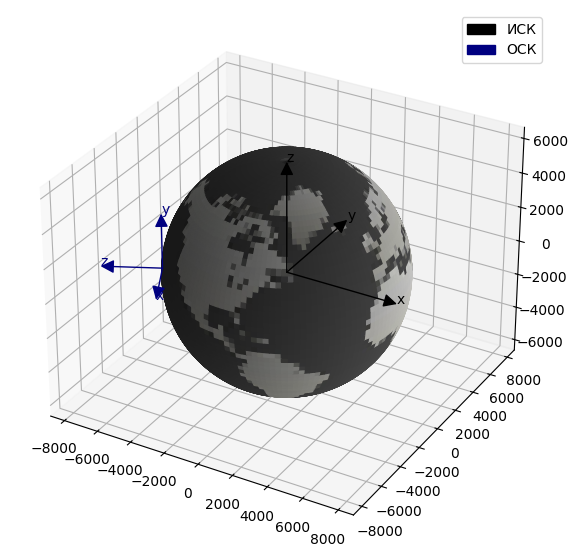

In [64]:
resolution = 3
t = hour2sec(1)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
ax = plot_the_earth(ax)
ax = plot_reference_frames(ax, txt="ИСК", color="k")
ax = plot_reference_frames(ax, txt="ОСК", color="navy")

ax.set_xlim3d([-2 ,2])
ax.set_ylim3d([-2 ,2])
ax.set_zlim3d([-2 ,2])
ax.axis('equal')
plt.legend()
plt.show()

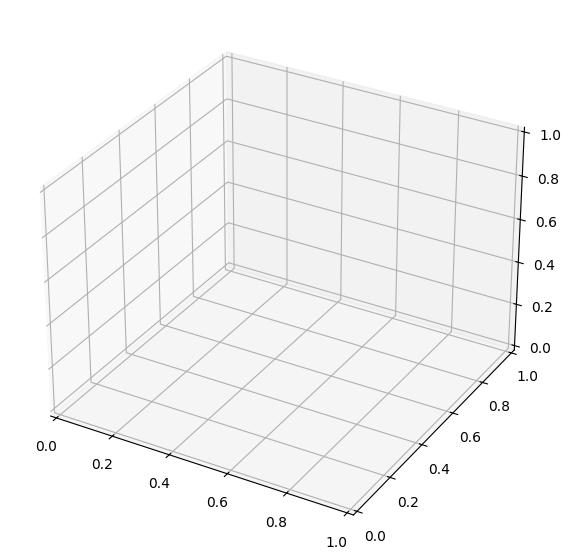

In [59]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

t_list = np.linspace(0, 3600, 10)

def animate(n):
    t = t_list[n]
    ax = plot_the_earth(ax)
    ax = plot_reference_frames(ax, txt="ИСК", color="k")
    ax = plot_reference_frames(ax, txt="ОСК", color="navy")
    # return line,

anim = animation.FuncAnimation(fig, animate, frames=len(t_list), interval=100)
plt.show()

### <span style="color:#0ab49a">Построение</span> <span style="color:#A254FC">динамики</span> 

In [5]:
from sympy import *

def get_vars(name: str, n: int, numb: bool = True):
    """Генерит символьные переменные с одинаковым названием и индексами 0...(n-1)
    :param name: Название переменных (без учёта индекса)
    :param n: Количество переменных"""
    s = ""
    axis = ["x", "y", "z"] if n == 3 else [0, "x", "y", "z"]
    for i in range(n):
        s += f"{name}_{i} " if numb else f"{name}_{axis[i]} "
    return var(s, real=True)

w = Matrix(get_vars("w", 3, numb=False))
q = Matrix(get_vars("q", 4, numb=False))
J = Matrix(get_vars("J", 3, numb=False))
M = Matrix(get_vars("M", 3, numb=False))
μ, R_0, w_0 = var("μ R_0 w_0", real=True, constant=True)
R_orb = Matrix([0, 0, R_0])
J = Matrix([[J_x, 0, 0],
            [0, J_y, 0],
            [0, 0, J_z]])
A = Matrix([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy + 2*qz*q0, 2*qx*qz - 2*qy*q0],
            [2*qx*qy - 2*qz*q0, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz + 2*qx*q0],
            [2*qx*qz + 2*qy*q0, 2*qy*qz - 2*qx*q0, 1 - 2*qx**2 - 2*qy**2]])

A

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,    2*q_0*q_z + 2*q_x*q_y,   -2*q_0*q_y + 2*q_x*q_z],
[  -2*q_0*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,    2*q_0*q_x + 2*q_y*q_z],
[   2*q_0*q_y + 2*q_x*q_z,   -2*q_0*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

In [6]:
J

Matrix([
[J_x,   0,   0],
[  0, J_y,   0],
[  0,   0, J_z]])

In [15]:
w_diff = J.inv() @ (- (w).cross(J @ w) + M)
print(w_diff[0])
print(w_diff[1])
print(w_diff[2])
w_diff

(J_{yy}*w_y*w_z - J_{zz}*w_y*w_z + M_x)/J_{xx}
(-J_{xx}*w_x*w_z + J_{zz}*w_x*w_z + M_y)/J_{yy}
(J_{xx}*w_x*w_y - J_{yy}*w_x*w_y + M_z)/J_{zz}


Matrix([
[ (J_{yy}*w_y*w_z - J_{zz}*w_y*w_z + M_x)/J_{xx}],
[(-J_{xx}*w_x*w_z + J_{zz}*w_x*w_z + M_y)/J_{yy}],
[ (J_{xx}*w_x*w_y - J_{yy}*w_x*w_y + M_z)/J_{zz}]])

### <span style="color:#0ab49a">Исследование</span> <span style="color:#A254FC">режимов вращения</span> 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [83]:
Cf = 1
m = 0.03
a = 0.1
b = 0.1

rho =  5.21e-13
S = a*b
M = 5.972e24
G = 6.6743e-11
mu = M * G
v_orb = np.sqrt(mu / 6900e3)
c = Cf * rho * v_orb**2 * S / 6 * m * (a**2 + a*b + b**2)
c

4.514455893826088e-11

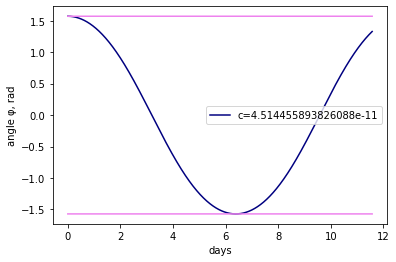

In [91]:
# p = phi
dt = 10.
T = 1e6
days = True

def func(p: float, w: float, c: float, dt: float):
    return p + w * dt, w - dt * c * np.sin(p)

def integrate(c: float, dt: float = 1., T: float = 1000):
    w_list = [0.]
    p_list = [3.1415/2]
    t_list = [0.]
    for i in range(int(round(T / dt))):
        tmp = func(p_list[i], w_list[i], c, dt)
        t_list += [(i+1)*dt]
        p_list += [tmp[0]]
        w_list += [tmp[1]]
    return t_list, p_list

t, p = integrate(c=c, dt=dt, T=T)
t = [i/(3600*24) for i in t] if days else t
plt.plot(t, np.array(p), c='navy', label=f"c={c}")  # /(np.pi/2)
plt.plot(t, [np.pi/2 for _ in range(len(t))], c='violet')
plt.plot(t,[-np.pi/2 for _ in range(len(t))], c='violet')
plt.legend()
plt.xlabel("days" if days else "time t, s")
plt.ylabel("angle φ, rad")
# plt.ylim([-np.pi/2, np.pi/2])
plt.show()

### <span style="color:#0ab49a">Движение со</span> <span style="color:#A254FC">смещённым центром масс</span> 

In [1]:
from sympy import *

In [46]:
a, b, ex, ey = var('a b e_x e_y', real=True, constant=True)  # Стороны ЧипСата, отклонения цетра масс
m, f, v = var('m f v', real=True, constant=True)
t = var('t', real=True, constant=False)
n_x = Function("n_x")(t)
n_y = Function("n_y")(t)
n_z = Function("n_z")(t)
w_x = Function("w_x")(t)
w_y = Function("w_y")(t)
w_z = Function("w_z")(t)
x0 = -a + ex
x1 = a + ex
y0 = -b + ey
y1 = b + ey
Ix = m/3 * (x1 - x0) * (y1**3 - y0**3)
Iy = m/3 * (y1 - y0) * (x0**3 - x1**3)
Iz = Ix + Iy  # верно для пластины
eq_n_x = Eq(n_x.diff(t), w_y*n_z - w_z*n_y)
eq_n_y = Eq(n_y.diff(t), w_z*n_x - w_x*n_z)
eq_n_z = Eq(n_z.diff(t), w_x*n_y - w_y*n_x)
eq_x = Eq(f*n_x*v*(x1-x0)*(y1**2-y0**2), Ix * w_x.diff(t) + (Iz - Iy)*w_y*w_z)
eq_y = Eq(f*n_x*v*(y1-y0)*(x0**2-x1**2), Iy * w_y.diff(t) + (Ix - Iz)*w_x*w_z)
eq_z = Eq(0, Iz * w_z.diff(t) + (Iy - Ix)*w_x*w_y)

In [17]:
anw = dsolve({eq_n_x, eq_n_y, eq_n_z, eq_x, eq_y, eq_z})

NotImplementedError: 